# DSAI HW1 Peak Load Forecasting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from scipy.optimize import minimize
from sklearn.model_selection import TimeSeriesSplit

In [2]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error

In [3]:
dataset = pd.read_csv('data/PL.csv', index_col=['Date'], parse_dates=['Date'])
holidays = pd.read_csv('data/holidays.csv')

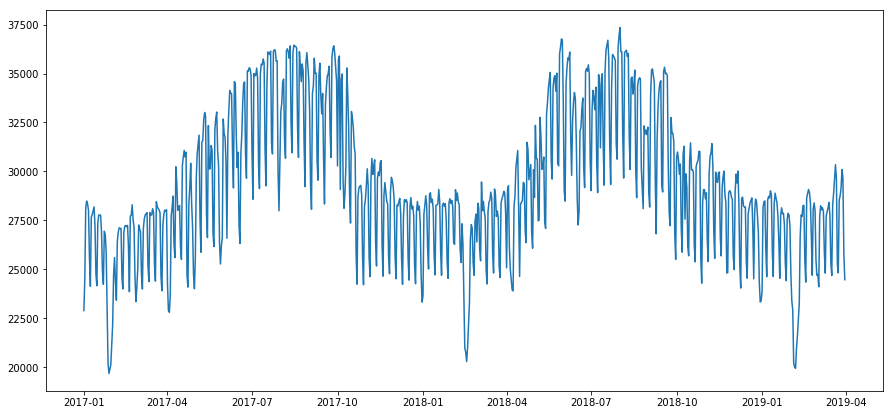

In [4]:
plt.figure(figsize=(15, 7))
plt.plot(dataset['PL'])

# SARIMA
SARIMA model is a traditional way to analysis a time series, and is convinent to explore some time series information such as seasonalities or autocorrelations. Thus, I decided to use this statistical method to learn more about this data.

## 1. Data preparation
The electricity loading data is a seasonal time series, therefore we can fit it with a (Seasonal)ARIMA model so as to predict with seasonality trend. Before implement a SARIMA model, we need some diagnosis and preparations in order to make the series "stationary."

In [5]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: pvalue={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

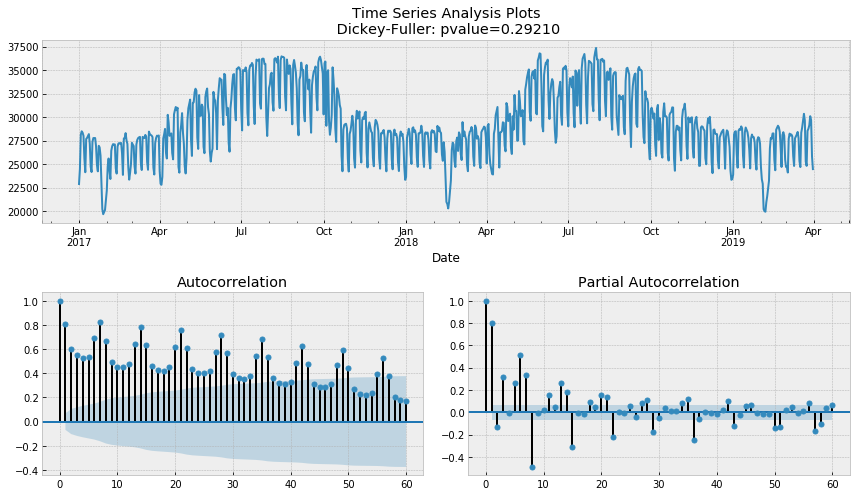

In [6]:
tsplot(dataset.PL, lags=60)

Dickey–Fuller test shows a p-value of 0.405, which means the null hypothesis of not stationary is not significant.
We need to difference it by 1 step.

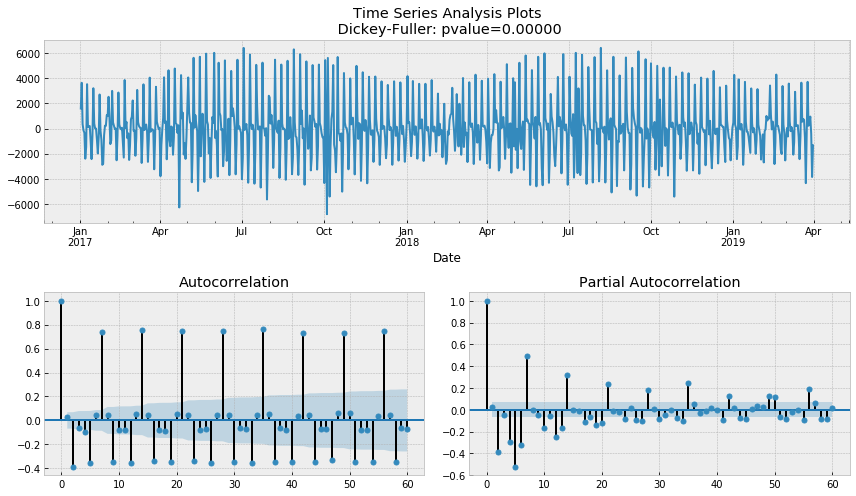

In [7]:
PL_diff = dataset.PL - dataset.PL.shift(1)
tsplot(PL_diff[1:], lags=60)

After differenced by 1 step, we can see that the series is more likely to be stationary, and the Dickey–Fuller p-value also become significant. However, ACF and PACF still show some significant steps repeat over days. That is, therefore, we still need to deal with its seasonality.

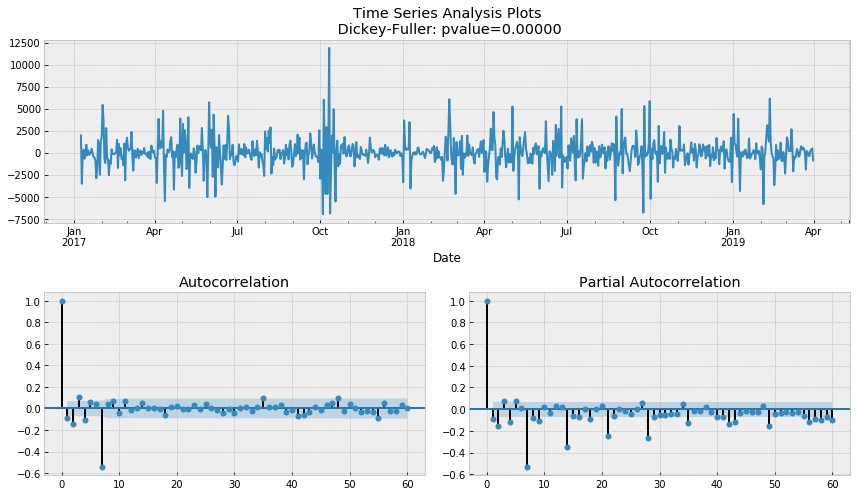

In [8]:
PL_diff = PL_diff - PL_diff.shift(7)
tsplot(PL_diff[7+1:], lags=60)

After difference 7 steps for seasonality, the series is now looks stationary. And later we can move on to select a SARIMA model.

## 2. Model selection

In [9]:
model = sm.tsa.statespace.SARIMAX(dataset.PL, order=(2, 1, 2), seasonal_order=(0, 1, 0, 365)).fit(disp=-1)

C:\Users\USER\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [10]:
print(model.summary())

                                  Statespace Model Results                                 
Dep. Variable:                                  PL   No. Observations:                  820
Model:             SARIMAX(2, 1, 2)x(0, 1, 0, 365)   Log Likelihood               -4237.333
Date:                             Mon, 01 Apr 2019   AIC                           8484.667
Time:                                     18:19:18   BIC                           8505.257
Sample:                                 01-01-2017   HQIC                          8492.779
                                      - 03-31-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3441      0.093     -3.685      0.000      -0.527      -0.161
ar.L2          0.1371      

In [11]:
def plotSARIMA(series, model, n_steps):
    
    # adding model values
    data = series.copy()
    fitted = data.copy()
    fitted = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    fitted[:s+d] = np.NaN
    
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = fitted.append(forecast)
    error = np.sqrt(mean_squared_error(data[s+d:], fitted[s+d:]))

    plt.figure(figsize=(15, 7))
    plt.title("RMSE: {0:.2f}".format(error))
    plt.plot(forecast, color='g', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data[s+d:], label="actual")
    plt.legend()
    plt.grid(True)
    
    return forecast

In [12]:
s=365 # season = 365 days
d=1 # difference = 1

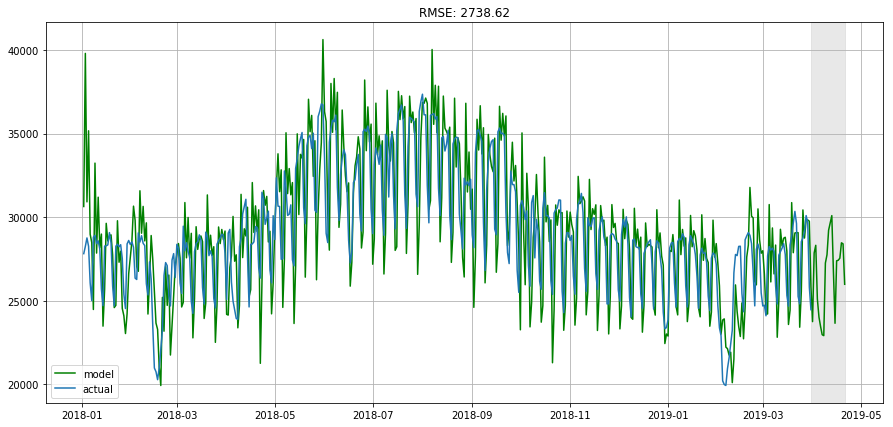

In [13]:
forecast = plotSARIMA(dataset.PL, model, 20)

After waiting a bit of time, the result comes out here is surprisingly amazing. The gray area in the plot is the prediction for the next 20 days (2019/4/1 ~ 2019/4/20). We can see that even if I didn't place any holiday information into this training, the prediction still shows a decrease in values during the holidays periods (2019/4/4 ~ 2019/4/7). I guess this result is attributed to the seasonality that I previously set into the model (s=365), and it ultimately resembles the same period appeared in the last 2 years.

# Linear Model

Due to the above result from SARIMA, I find that it is hard to tune its parameters, and is time consuming as well. Therefore, it is sometime much easier to prepare some simple features and build a simple regression model.

## Feature Exctraction
I only do 2 steps here:
* create lags features
* create holidays and weekend features

Loading data used to be highly correlated to different date time, says in the weekend most people stay at home, causing decrease on the electricity loading, and vice versa, creating holidays and weekend information is therefore reasonable.

### 1. Create Lags
Create lags for 2 weeks

In [14]:
data = pd.DataFrame(dataset.PL.copy())
data.columns = ["y"]

In [15]:
def create_lags(data):
    for i in range(1, 15):
        data["lag_{}".format(i)] = data.y.shift(i)
    return data

data = create_lags(data)
data.tail(7)

,y,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14
Date,,,,,,,,,,,,,,,
2019-03-25,28535,24812.0,25265.0,29618.0,30343.0,29645.0,28882.0,28338.0,24681.0,25318.0,27757.0,28417.0,28145.0,27936.0,27730.0
2019-03-26,28756,28535.0,24812.0,25265.0,29618.0,30343.0,29645.0,28882.0,28338.0,24681.0,25318.0,27757.0,28417.0,28145.0,27936.0
2019-03-27,29140,28756.0,28535.0,24812.0,25265.0,29618.0,30343.0,29645.0,28882.0,28338.0,24681.0,25318.0,27757.0,28417.0,28145.0
2019-03-28,30093,29140.0,28756.0,28535.0,24812.0,25265.0,29618.0,30343.0,29645.0,28882.0,28338.0,24681.0,25318.0,27757.0,28417.0
2019-03-29,29673,30093.0,29140.0,28756.0,28535.0,24812.0,25265.0,29618.0,30343.0,29645.0,28882.0,28338.0,24681.0,25318.0,27757.0
2019-03-30,25810,29673.0,30093.0,29140.0,28756.0,28535.0,24812.0,25265.0,29618.0,30343.0,29645.0,28882.0,28338.0,24681.0,25318.0
2019-03-31,24466,25810.0,29673.0,30093.0,29140.0,28756.0,28535.0,24812.0,25265.0,29618.0,30343.0,29645.0,28882.0,28338.0,24681.0


### 2. Create weekend and holidays

In [16]:
data.index = pd.to_datetime(data.index, format='%Y/%m/%d')
data["weekday"] = data.index.weekday
data['is_weekend'] = data.weekday.isin([5,6])*1

In [17]:
# Add Taiwanese holidays 
data['datetime'] = data.index
i,j = 0,0
for holiday in holidays.date:
    holiday = pd.to_datetime(holiday, format='%Y/%m/%d')
    holiday = holiday.strftime("%Y/%m/%d")
    for datetime in data.datetime:
        datetime = datetime.strftime("%Y/%m/%d")
        if datetime == holiday:
            data.iloc[j, 16] = holidays['isHoliday'][i]
        j = j + 1
    i = i + 1
    j = 0
    
data = data.drop(['datetime'], axis=1)
data.tail()

,y,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,weekday,is_weekend
Date,,,,,,,,,,,,,,,,,
2019-03-27,29140,28756.0,28535.0,24812.0,25265.0,29618.0,30343.0,29645.0,28882.0,28338.0,24681.0,25318.0,27757.0,28417.0,28145.0,2,0
2019-03-28,30093,29140.0,28756.0,28535.0,24812.0,25265.0,29618.0,30343.0,29645.0,28882.0,28338.0,24681.0,25318.0,27757.0,28417.0,3,0
2019-03-29,29673,30093.0,29140.0,28756.0,28535.0,24812.0,25265.0,29618.0,30343.0,29645.0,28882.0,28338.0,24681.0,25318.0,27757.0,4,0
2019-03-30,25810,29673.0,30093.0,29140.0,28756.0,28535.0,24812.0,25265.0,29618.0,30343.0,29645.0,28882.0,28338.0,24681.0,25318.0,5,1
2019-03-31,24466,25810.0,29673.0,30093.0,29140.0,28756.0,28535.0,24812.0,25265.0,29618.0,30343.0,29645.0,28882.0,28338.0,24681.0,6,1


In [18]:
# Accumulate consecutive holidays
data['NOH'] = data['is_weekend']

i = 0
accumulation = 0
for day in data['NOH']:
#     print(day)
    if day == 0:
        accumulation = 0
    elif day == 1:
        accumulation = accumulation + 1
    data.iloc[i, 17] = accumulation
    i = i + 1

data.tail(10)

,y,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,weekday,is_weekend,NOH
Date,,,,,,,,,,,,,,,,,,
2019-03-22,29618,30343.0,29645.0,28882.0,28338.0,24681.0,25318.0,27757.0,28417.0,28145.0,27936.0,27730.0,24801.0,25870.0,27951.0,4,0,0
2019-03-23,25265,29618.0,30343.0,29645.0,28882.0,28338.0,24681.0,25318.0,27757.0,28417.0,28145.0,27936.0,27730.0,24801.0,25870.0,5,1,1
2019-03-24,24812,25265.0,29618.0,30343.0,29645.0,28882.0,28338.0,24681.0,25318.0,27757.0,28417.0,28145.0,27936.0,27730.0,24801.0,6,1,2
2019-03-25,28535,24812.0,25265.0,29618.0,30343.0,29645.0,28882.0,28338.0,24681.0,25318.0,27757.0,28417.0,28145.0,27936.0,27730.0,0,0,0
2019-03-26,28756,28535.0,24812.0,25265.0,29618.0,30343.0,29645.0,28882.0,28338.0,24681.0,25318.0,27757.0,28417.0,28145.0,27936.0,1,0,0
2019-03-27,29140,28756.0,28535.0,24812.0,25265.0,29618.0,30343.0,29645.0,28882.0,28338.0,24681.0,25318.0,27757.0,28417.0,28145.0,2,0,0
2019-03-28,30093,29140.0,28756.0,28535.0,24812.0,25265.0,29618.0,30343.0,29645.0,28882.0,28338.0,24681.0,25318.0,27757.0,28417.0,3,0,0
2019-03-29,29673,30093.0,29140.0,28756.0,28535.0,24812.0,25265.0,29618.0,30343.0,29645.0,28882.0,28338.0,24681.0,25318.0,27757.0,4,0,0
2019-03-30,25810,29673.0,30093.0,29140.0,28756.0,28535.0,24812.0,25265.0,29618.0,30343.0,29645.0,28882.0,28338.0,24681.0,25318.0,5,1,1


In [19]:
# convert to float type
data = data.astype(float)

## Modeling
* Linear Regression
* LightGBM

In [20]:
def plotModelResults(model, X_train, X_test):
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    error = np.sqrt(mean_squared_error(prediction, y_test))
    plt.title("RMSE: {0:.2f}".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True)

In [21]:
def timeseries_train_test_split(X, y, test_size):
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

### 1. Linear Regression

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

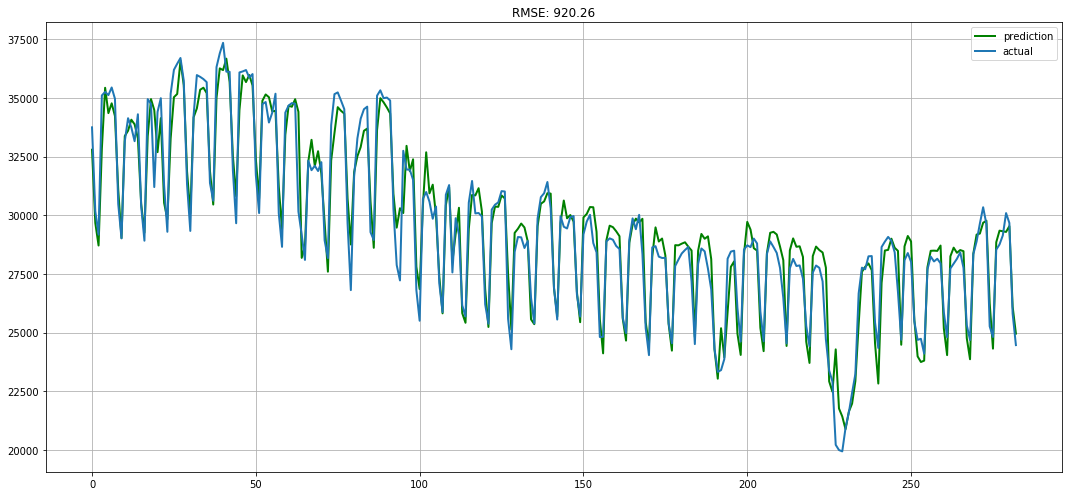

In [23]:
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.35)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

LRmodel = LinearRegression()
LRmodel.fit(X_train_scaled, y_train)

plotModelResults(LRmodel, X_train=X_train_scaled, X_test=X_test_scaled)

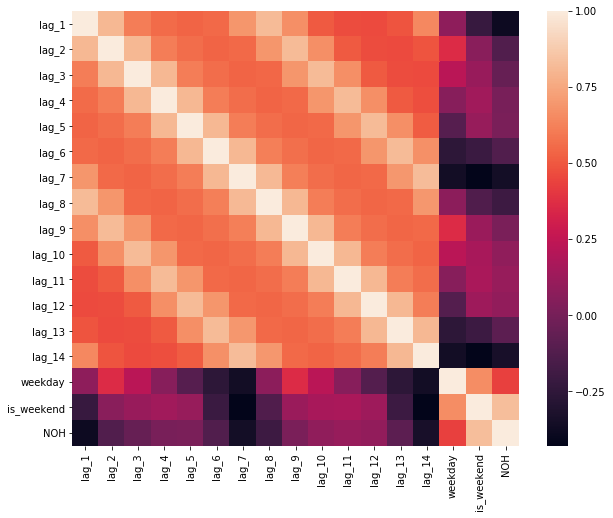

In [24]:
import seaborn as sns 
plt.figure(figsize=(10, 8))
sns.heatmap(X_train.corr());

This is the correlation matrix of the features used in the model. Observe that each lag is highly correlated to the lags around 7 days latter.

### 2. LightGBM

In [25]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split

train_data=lgb.Dataset(X_train_scaled,label=y_train)
valid_data=lgb.Dataset(X_test_scaled,label=y_test)

In [26]:
# Well-tuned parameters
params = {'boosting_type': 'gbdt',
          'max_depth' : -1,
          'objective': 'regression',
          'nthread': 4,
          'num_leaves': 34,
          'learning_rate': 0.005,
          'subsample': 0.8,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'min_split_gain': 0.5,
          'min_child_weight': 1,
          'min_child_samples': 1,
          'metric' : 'rmse'
          }

In [27]:
# train the model
lgbm = lgb.train(params,
                 train_data,
                 25000,
                 valid_sets=valid_data,
                 early_stopping_rounds= 40,
                 verbose_eval= 4
                 )

Training until validation scores don't improve for 40 rounds.
[4]	valid_0's rmse: 3577.98
[8]	valid_0's rmse: 3512.54
[12]	valid_0's rmse: 3448.31
[16]	valid_0's rmse: 3385.29
[20]	valid_0's rmse: 3324.69
[24]	valid_0's rmse: 3263.96
[28]	valid_0's rmse: 3206.99
[32]	valid_0's rmse: 3149.03
[36]	valid_0's rmse: 3093.81
[40]	valid_0's rmse: 3040.25
[44]	valid_0's rmse: 2987.62
[48]	valid_0's rmse: 2935.49
[52]	valid_0's rmse: 2883.07
[56]	valid_0's rmse: 2831.95
[60]	valid_0's rmse: 2782.76
[64]	valid_0's rmse: 2734.2
[68]	valid_0's rmse: 2686.57
[72]	valid_0's rmse: 2642.38
[76]	valid_0's rmse: 2597.21
[80]	valid_0's rmse: 2554.04
[84]	valid_0's rmse: 2511.73
[88]	valid_0's rmse: 2468.88
[92]	valid_0's rmse: 2427.95
[96]	valid_0's rmse: 2388.17
[100]	valid_0's rmse: 2348
[104]	valid_0's rmse: 2308.68
[108]	valid_0's rmse: 2270.51
[112]	valid_0's rmse: 2234.74
[116]	valid_0's rmse: 2198.25
[120]	valid_0's rmse: 2164.23
[124]	valid_0's rmse: 2128.74
[128]	valid_0's rmse: 2095.18
[132]	va

[1096]	valid_0's rmse: 841.22
[1100]	valid_0's rmse: 841.12
[1104]	valid_0's rmse: 841.066
[1108]	valid_0's rmse: 840.929
[1112]	valid_0's rmse: 840.877
[1116]	valid_0's rmse: 840.764
[1120]	valid_0's rmse: 840.753
[1124]	valid_0's rmse: 840.666
[1128]	valid_0's rmse: 840.631
[1132]	valid_0's rmse: 840.507
[1136]	valid_0's rmse: 840.489
[1140]	valid_0's rmse: 840.533
[1144]	valid_0's rmse: 840.449
[1148]	valid_0's rmse: 840.376
[1152]	valid_0's rmse: 840.427
[1156]	valid_0's rmse: 840.382
[1160]	valid_0's rmse: 840.261
[1164]	valid_0's rmse: 840.173
[1168]	valid_0's rmse: 840.06
[1172]	valid_0's rmse: 839.87
[1176]	valid_0's rmse: 839.775
[1180]	valid_0's rmse: 839.732
[1184]	valid_0's rmse: 839.616
[1188]	valid_0's rmse: 839.572
[1192]	valid_0's rmse: 839.575
[1196]	valid_0's rmse: 839.567
[1200]	valid_0's rmse: 839.624
[1204]	valid_0's rmse: 839.669
[1208]	valid_0's rmse: 839.604
[1212]	valid_0's rmse: 839.543
[1216]	valid_0's rmse: 839.527
[1220]	valid_0's rmse: 839.582
[1224]	valid

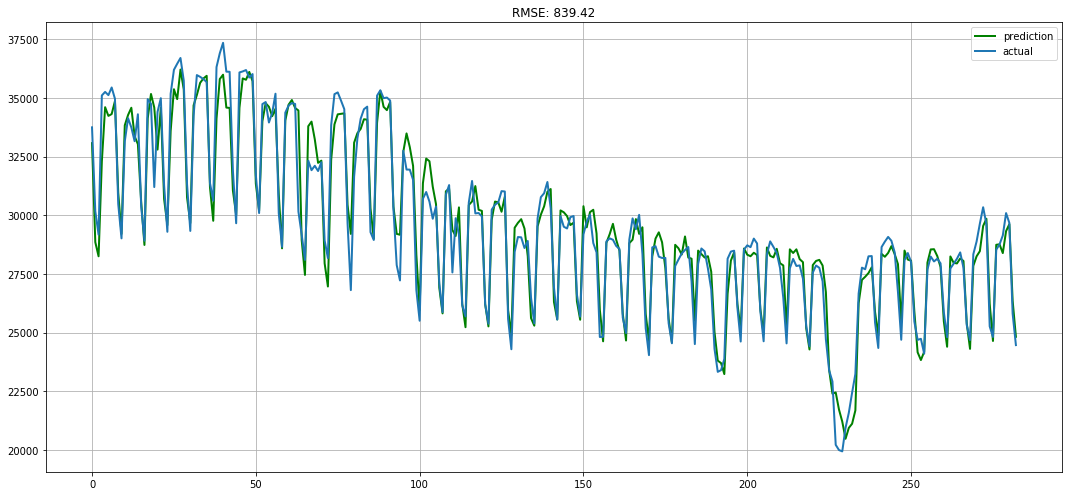

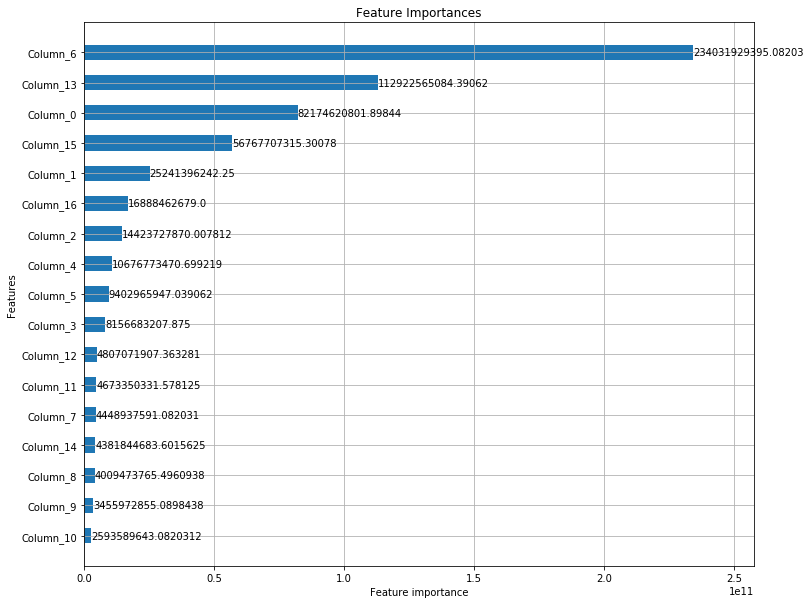

In [28]:
plotModelResults(lgbm, X_train=X_train_scaled, X_test=X_test_scaled)
lgb.plot_importance(lgbm, height=0.5, ignore_zero = False, figsize = (12,10), importance_type ='gain')
plt.title("Feature Importances")
plt.show()

LightGBM shows a great result of fitting these testing data, and eventually get a RMSE of 840.65, which is the minimum of above methods. In addition, the feature importance plot shows an interesting but foreseeable result that 'lag7', 'lag14', 'lag1', and 'is_weekend' features got the score much higher than other features. That is, LightGBM model will put most of its effort fitting the testing data base on these top-scored features.

# Submission
Finally, I choose the result from LightGBM, which has a minumum RMSE compared to all other methods, for the final submission.

In [29]:
def create_lags(data):
    for i in range(1, 15):
        data["lag_{}".format(i)] = data.y.shift(i)
    return data

test_features = data.append({'y':0},ignore_index=True)
test_features = create_lags(test_features)
test_features = test_features[-1:]

In [30]:
is_weekend = [0, 0, 0, 1, 1, 1, 1, 0]
NOH = [0, 0, 0, 1, 2, 3, 4, 0]
weekday = [0, 1, 2, 3, 4, 5, 6, 0]

# setup daily features
test_features['weekday'] = weekday[0]
test_features['is_weekend'] = is_weekend[0]
test_features['NOH'] = NOH[0]

# Predict for the first day
test_features.astype(float)
test_features_scaled = scaler.transform(test_features.drop(['y'], axis=1))
predictions_lgbm_prob = lgbm.predict(test_features_scaled).round(decimals=3)
test_features.iloc[0, 0] = predictions_lgbm_prob
test_features = test_features.append({'y':0},ignore_index=True)

# setup features and predict for the remaining days
for i in range(1, 8):
    for j in range(1, 15):
        test_features.iloc[i, j] = test_features.iloc[i-1, j-1]
    print(test_features.iloc[i, 1])
    test_features.iloc[i, 15] = weekday[i]
    test_features.iloc[i, 16] = is_weekend[i]
    test_features.iloc[i, 17] = NOH[i]
    
    test_features.astype(float)
    test_features_scaled = scaler.transform(test_features.drop(['y'], axis=1))
    predictions_lgbm_prob = lgbm.predict(test_features_scaled).round(decimals=3)
    test_features.iloc[i, 0] = predictions_lgbm_prob[-1]
    
    test_features = test_features.append({'y':0},ignore_index=True)

29196.22
29635.411
29410.278
27895.288
26000.465
24601.477
23937.667


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  if sys.path[0] == '':


In [31]:
test_features

,y,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,weekday,is_weekend,NOH
0,29196.220,24466.000,25810.000,29673.000,30093.000,29140.000,28756.000,28535.00,24812.0,25265.0,29618.0,30343.0,29645.0,28882.0,28338.0,0.0,0.0,0.0
1,29635.411,29196.220,24466.000,25810.000,29673.000,30093.000,29140.000,28756.00,28535.0,24812.0,25265.0,29618.0,30343.0,29645.0,28882.0,1.0,0.0,0.0
2,29410.278,29635.411,29196.220,24466.000,25810.000,29673.000,30093.000,29140.00,28756.0,28535.0,24812.0,25265.0,29618.0,30343.0,29645.0,2.0,0.0,0.0
3,27895.288,29410.278,29635.411,29196.220,24466.000,25810.000,29673.000,30093.00,29140.0,28756.0,28535.0,24812.0,25265.0,29618.0,30343.0,3.0,1.0,1.0
4,26000.465,27895.288,29410.278,29635.411,29196.220,24466.000,25810.000,29673.00,30093.0,29140.0,28756.0,28535.0,24812.0,25265.0,29618.0,4.0,1.0,2.0
5,24601.477,26000.465,27895.288,29410.278,29635.411,29196.220,24466.000,25810.00,29673.0,30093.0,29140.0,28756.0,28535.0,24812.0,25265.0,5.0,1.0,3.0
6,23937.667,24601.477,26000.465,27895.288,29410.278,29635.411,29196.220,24466.00,25810.0,29673.0,30093.0,29140.0,28756.0,28535.0,24812.0,6.0,1.0,4.0
7,28291.938,23937.667,24601.477,26000.465,27895.288,29410.278,29635.411,29196.22,24466.0,25810.0,29673.0,30093.0,29140.0,28756.0,28535.0,0.0,0.0,0.0
8,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
# construct submission dataframe
date = ['20190402', '20190403', '20190404', '20190405', '20190406', '20190407', '20190408']
pl = test_features['y'][1:-1]

submission_dict = {'date':date, 'peak_load(MW)':pl}
submission = pd.DataFrame(submission_dict)
submission

,date,peak_load(MW)
1,20190402,29635.411
2,20190403,29410.278
3,20190404,27895.288
4,20190405,26000.465
5,20190406,24601.477
6,20190407,23937.667
7,20190408,28291.938


In [33]:
# save as csv file
submission.to_csv("../submission.csv", index=False)